In [0]:
import pandas as pd
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm_notebook
import pywt
url='https://raw.githubusercontent.com/huddyyeo/RL_for_trading/master/HSBA.L.csv'
start_date='2000-01-01'

# silence warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

!pip install ta
import ta


In [0]:
from google.colab import drive
drive.mount('/content/drive/')
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu') #using GPU
else:
    device = torch.device('cpu')
    print('using cpu') #using CPU

In [0]:
def wavelet(data,wave_type='sym4',threshold=0.04):
  w = pywt.Wavelet('sym4')
  maxlev = pywt.dwt_max_level(len(data), w.dec_len)
  coeffs = pywt.wavedec(data, wave_type, level=maxlev)
  for i in range(1,len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
  return pywt.waverec(coeffs, wave_type)


In [0]:
#scaler class, reduces values to 0-1

class MinMaxScaler():
  
  def __init__(self,scale=[0,1]):
    self.min=scale[0]
    self.scale=1/(scale[1]-scale[0])
    
  def fit_transform(self, array):
    length=array.shape[1]
    final_array = np.zeros(array.shape)
    self.scale=np.zeros(length)
    self.min=np.zeros(length)
    
    for i in range(length):
      scale=np.max(array[:,i])-np.min(array[:,i])
      if (scale==0):
        scale=1
      scale=1/scale
      self.scale[i]=scale
      self.min[i]=np.min(array[:,i])
      final_array[:,i]=(array[:,i]-np.min(array[:,i]))*scale
    return final_array
  
  def inverse_transform(self,array):
    final_array = np.zeros(array.shape)
    for i in range(array.shape[1]):
      final_array[:,i]=(array[:,i]/self.scale[i])+self.min[i]
    return final_array
  
  def transform(self,array):
    final_array=np.zeros(array.shape)
    for i in range(array.shape[1]):
      final_array[:,i]=(array[:,i]-self.min[i])*self.scale[i]
    return final_array

In [0]:
class Environment(object):
  def __init__(self,url,start_date,val_count=0.8,test_count=0.90):
    
    self.training_window=253
    self.url=url
    self.start_date=start_date
    self.scaler=MinMaxScaler()

    self.market_data=self.init_data(url,start_date)
    self.log_returns,self.returns=self.init_labels()    
    
    self.num_days=len(self.market_data)   
    self.val_count=int(self.num_days*val_count)
    self.test_count=int(self.num_days*test_count)
    
    self.scaled_market_data=self.scale_data()

  def scale_data(self):           
    all_data=self.market_data.copy().values
    all_data[:self.val_count]=self.scaler.fit_transform(all_data[:self.val_count])
    all_data[self.val_count:]=self.scaler.transform(all_data[self.val_count:])
    return all_data
    
  def init_data(self,url,start_date):
    #retrieving data
    data=pd.read_csv(url)
    data.at[8002,'Low']=data.loc[8001,'Low'] #correcting a specific error in the raw data
    data=data[data['Date']>=start_date]
    data=data.reset_index().drop(columns=['Adj Close','index'])
    data=self.pre_process(data)
    #data=self.denoise(data)
    return data
  
  def denoise(self,data):
    data.at[:,'High']=pd.Series(wavelet(data.loc[:,"High"].values,wave_type='sym4',threshold=0.05))
    data.at[:,'Low']=pd.Series(wavelet(data.loc[:,"Low"].values,wave_type='sym4',threshold=0.05))
    return data

  def init_labels(self):
    #calculate returns
    current_day_high=self.market_data.loc[:,'High']
    current_day_low=self.market_data.loc[:,'Low']
    next_day_high=current_day_high.shift(-1)
    next_day_low=current_day_low.shift(-1)
    returns_high=next_day_high/current_day_high
    returns_low=next_day_low/current_day_low
    log_returns_high=np.log(returns_high).values
    log_returns_high=np.expand_dims(log_returns_high,axis=1)
    log_returns_low=np.log(returns_low).values
    log_returns_low=np.expand_dims(log_returns_low,axis=1)

    returns=pd.concat([returns_high,returns_low],axis=1)
    log_returns=np.concatenate([log_returns_high,log_returns_low],axis=1)
    return log_returns,returns
  
  def get_indicators(self,data):
    #calculate all indicators
    open=data.loc[:,'Open']
    high=data.loc[:,'High']
    low=data.loc[:,'Low']
    close=data.loc[:,'Close']
    volume=data.loc[:,'Volume']
    
    data['rsi']=ta.momentum.rsi(close)
    data['uo']=ta.momentum.uo(high,low,close)
    data['kama']=ta.momentum.ao(high, low)
    
    data['eom']=ta.volume.ease_of_movement(high, low, close, volume)
    data['cmd']=ta.volume.chaikin_money_flow(high, low, close, volume)
    data['nvi']=ta.volume.negative_volume_index(close, volume)
    
    data['boll_high']=ta.volatility.bollinger_hband_indicator(close)
    data['atr']=ta.volatility.average_true_range(high, low, close)
     
    data['aroon']=ta.trend.aroon_down(close)
    data['dpo']=ta.trend.dpo(close)
    data['macd_diff']=ta.trend.macd_diff(close)
    data['vortex']=ta.trend.vortex_indicator_neg(high, low, close)
    
    return data
  
  def pre_process(self,data):
    data['Date']=pd.to_datetime(data['Date'])
    data=data.resample('D',on='Date').first().fillna(method='ffill')
    data=self.get_indicators(data)
    data=data.dropna()
    data=data.drop(columns=['Date'])

    return data
    

In [0]:
environment=Environment(url,start_date)

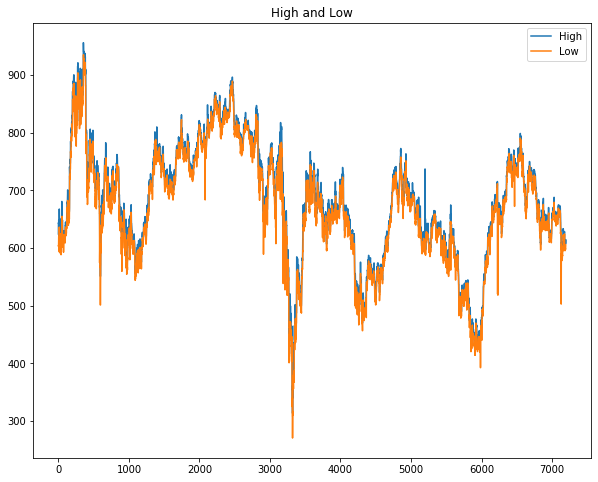

In [8]:
plt.figure(figsize=[10,8])
plt.title('High and Low')
plt.plot(environment.market_data.loc[:,"High"].values,label='High')
plt.plot(environment.market_data.loc[:,"Low"].values,label='Low')
plt.legend()
plt.show()

The training data looks somewhat stationary with no major, consistent trends. Thus appears to be a good training dataset.

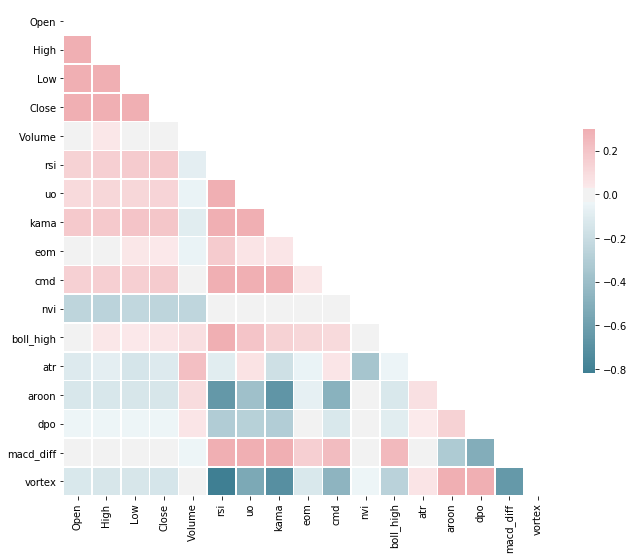

In [9]:
#correlation matrix of indicators, n
corr=environment.market_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [0]:
class DeepNetwork(nn.Module):
  def __init__(self,dim_0,dim_1=400,dim_2=400,dim_a=400,dropout=0.25,gru_layers=1):
    super(DeepNetwork,self).__init__()
    self.dim_0=dim_0
    self.dim_1=dim_1
    self.dim_2=dim_2    
    self.dim_a=dim_a

    self.linear=nn.Linear(dim_0,dim_1) 
    self.gru=nn.GRU(dim_1,dim_2,batch_first=True,num_layers=gru_layers)
    self.linear_a1=nn.Linear(dim_2,dim_a)
    self.linear_a2=nn.Linear(dim_a,dim_2)
    self.linear_out=nn.Linear(dim_2,2)

    self.dropout=nn.Dropout(dropout)
    
    self.relu=nn.ReLU()
    self.tanh=nn.Tanh() 
    self.sigmoid=nn.Sigmoid()
    self.softmax=nn.Softmax()
    
  def forward(self,x):
    
    #linear layer and relu
    out=self.linear(x) 
    out=self.dropout(out)
    out=self.relu(out) 

    #GRU
    out,_=self.gru(out,)

    #soft attention
    a=self.linear_a1(out)
    a=self.dropout(a)
    a=self.relu(a)
    a=self.linear_a2(out)
    a=self.dropout(a)
    a=self.tanh(a)
    a=self.softmax(a)
    a=a*out

    #linear layer and relu     
    out=self.linear_out(a)
    out=self.tanh(out)+1
    
    return out
  

class TrainingEnv():
  def __init__(self,environment,dim_1=400,dim_2=400,dim_a=400,lr=1e-5):
    dim_0=environment.scaled_market_data.shape[-1]
    self.model=DeepNetwork(dim_0=dim_0,dim_1=dim_1,dim_2=dim_2,gru_layers=1)
    self.model.to(device)
    self.training_hidden=None
    self.test_hidden=None
    self.count=0
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr,amsgrad=True)
    self.environment=environment
    self.criterion = nn.MSELoss()
    self.training_loss=[]
    self.lr=lr
    
  def reset_hidden(self):
    self.training_hidden=None
    self.test_hidden=None
    
  def train_once(self,training_data,label_data):
    #training one sample
    train=Variable(torch.from_numpy(training_data)).float().to(device)
    label=Variable(torch.from_numpy(label_data)).float().to(device)
    self.model.train()
    self.optimizer.zero_grad()
    

    out=self.model(train)
    out=out[:,-1,:]
    loss=self.criterion(out,label)
    loss.backward()
    self.optimizer.step()
    return loss.item()

  def train_one_epoch(self):
    loss=np.array([])
    #randomize the training windows
    window=self.environment.training_window
    train_space=np.arange(self.environment.val_count-window)
    total=len(train_space)
    np.random.shuffle(train_space)
    train_space=np.nditer(train_space)
    print('training...')
    for date in tqdm_notebook(train_space,total=total):
      train=self.environment.scaled_market_data[date:date+window]
      train=np.expand_dims(train,axis=0)
      label=self.environment.log_returns[date+window-1]
      loss=np.append(loss,self.train_once(train,label))
    print('completed training')
    self.evaluate_model()
    return(np.mean(loss))

  def get_val_loss(self):
    start=self.environment.val_count
    end=self.environment.test_count
    val_data=self.environment.scaled_market_data[start-self.environment.training_window:end]
    label=self.environment.log_returns[start:end]
    val_loss=self.model_eval(val_data)
    val_loss=val_loss[self.environment.training_window:]
    hmse=val_loss[:,0]-label[:,0]
    hmse=np.mean(np.square(hmse))
    lmse=val_loss[:,1]-label[:,1]
    lmse=np.mean(np.square(lmse))
    return(hmse,lmse)

  def model_eval(self,eval_data):
    #feed given eval data through network
    eval_data=np.expand_dims(eval_data,axis=0)
    eval=Variable(torch.from_numpy(eval_data)).float().to(device)
    self.model.eval()
    with torch.no_grad():
      out=self.model(eval)
    return np.squeeze(out.cpu().detach().numpy())

  def evaluate_model(self,a=10,b=8):    
    #evaluation of test set
    index=len(self.environment.market_data)-self.environment.test_count
    start=self.environment.test_count-self.environment.training_window
    out=self.model_eval(self.environment.scaled_market_data[start:])
    out=out[self.environment.training_window:]
    #invert the log returns to prices
    high=np.exp(out[:,0])*self.environment.market_data.loc[:,'High'].values[-1*index:]
    high=high[:-1] #remove last point 
    low=np.exp(out[:,1])*self.environment.market_data.loc[:,'Low'].values[-1*index:]
    low=low[:-1]

    plt.figure(figsize=[a,b])

    plt.subplot(2,1,1)
    plt.plot(high,label='pred high')
    plt.plot(self.environment.market_data.loc[:,'High'].values[-1*index+1:],label='actual')
    plt.legend()
    mse=self.environment.market_data.loc[:,'High'].values[-1*index+1:]-high
    mse=np.mean(np.square(mse))
    print('High MSE:',mse)

    plt.subplot(2,1,2)
    plt.plot(low,label='pred low')
    plt.plot(self.environment.market_data.loc[:,'Low'].values[-1*index+1:],label='actual')    
    plt.legend()
    plt.show()
    mse=self.environment.market_data.loc[:,'Low'].values[-1*index+1:]-low
    mse=np.mean(np.square(mse))
    print('Low MSE:',mse)

  def train(self):
    early_stop=3
    count=0
    val_loss=[]
    train_loss=[]
    min_val_loss=np.inf
    
    for epoch in range(20):
      print('Epoch:',epoch)
      loss=self.train_one_epoch()
      print('Training loss:',loss)
      train_loss.append(loss)
      high_loss,low_loss=self.get_val_loss()
      print('Val loss high:',high_loss)
      print('Val loss low:',low_loss)
      loss=(high_loss+low_loss)/2
      print('Avg val loss',loss)
      val_loss.append(loss)
      if loss<min_val_loss:
        count=0
        min_val_loss=loss
        torch.save(self.model.state_dict(),'checkpoint.pth')
        print('val loss decreased')
      else:
        count+=1
        self.lr=self.lr*0.5
        early_stop+=1
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr,amsgrad=True)
        self.model.load_state_dict(torch.load('checkpoint.pth'))
        print('val loss increased')
      if count>early_stop:
        print('Early stopping activated')
        break
    
    plt.figure(figsize=[8,6])
    plt.plot(val_loss,label='Validation loss')
    plt.plot(train_loss,label='Training loss')
    plt.legend()



Epoch: 0
training...


completed training
High MSE: 35.32628969552358


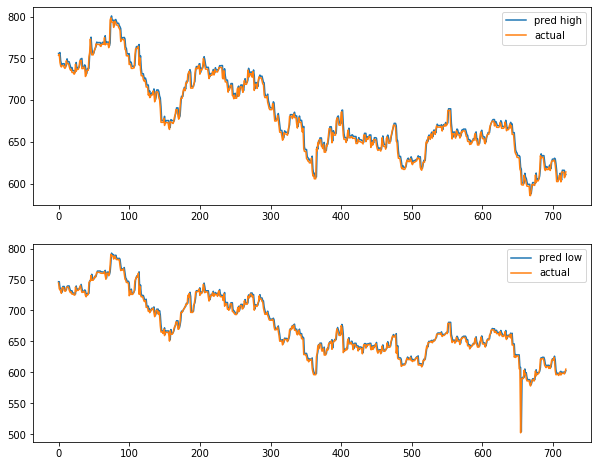

Low MSE: 62.585943755549664
Training loss: 0.01676847780628723
Val loss high: 0.0001276484327297017
Val loss low: 0.0004956758390594566
Avg val loss 0.0003116621358945791
val loss decreased
Epoch: 1
training...


completed training
High MSE: 32.77935281711979


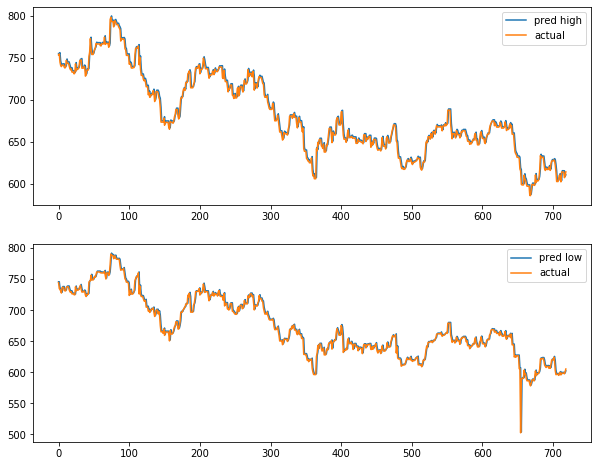

Low MSE: 60.48102549624715
Training loss: 0.00021207797738668504
Val loss high: 0.00011964886834150642
Val loss low: 0.0004884384908860102
Avg val loss 0.0003040436796137583
val loss decreased
Epoch: 2
training...


completed training
High MSE: 31.926113301462934


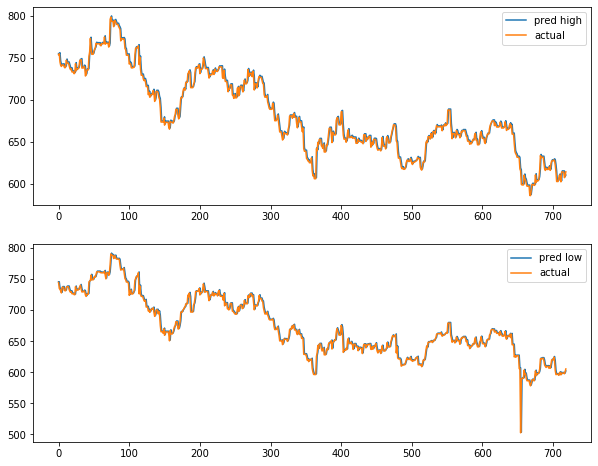

Low MSE: 59.798878712320295
Training loss: 0.00020538120871817117
Val loss high: 0.00011730176537870034
Val loss low: 0.0004864126010918895
Avg val loss 0.00030185718323529493
val loss decreased
Epoch: 3
training...


completed training
High MSE: 31.484173818205218


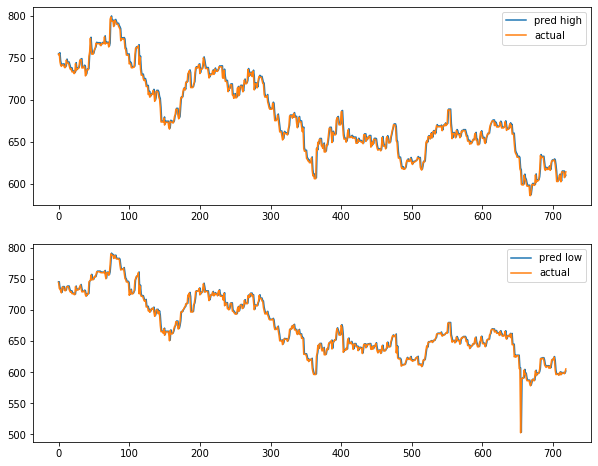

Low MSE: 59.45208512842426
Training loss: 0.00020263830855149278
Val loss high: 0.00011618897987351457
Val loss low: 0.0004854802559067052
Avg val loss 0.0003008346178901099
val loss decreased
Epoch: 4
training...


completed training
High MSE: 31.205925199956777


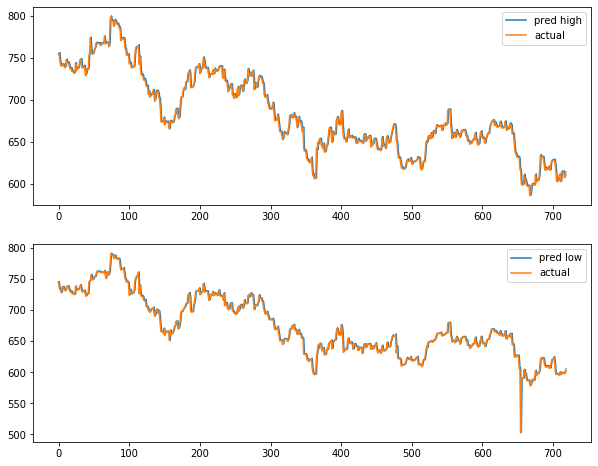

Low MSE: 59.23887895606078
Training loss: 0.0002012984836063755
Val loss high: 0.00011553567117824156
Val loss low: 0.0004849497781638942
Avg val loss 0.0003002427246710679
val loss decreased
Epoch: 5
training...


completed training
High MSE: 31.016444368403597


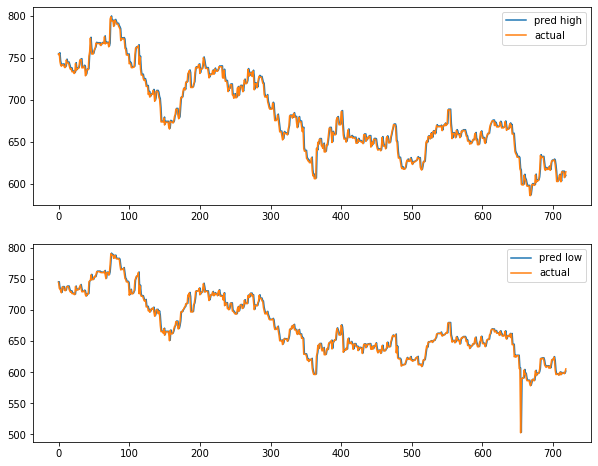

Low MSE: 59.09336257151531
Training loss: 0.00020036855193419732
Val loss high: 0.00011511569484319715
Val loss low: 0.0004846109792374602
Avg val loss 0.0002998633370403287
val loss decreased
Epoch: 6
training...


completed training
High MSE: 30.876581368261636


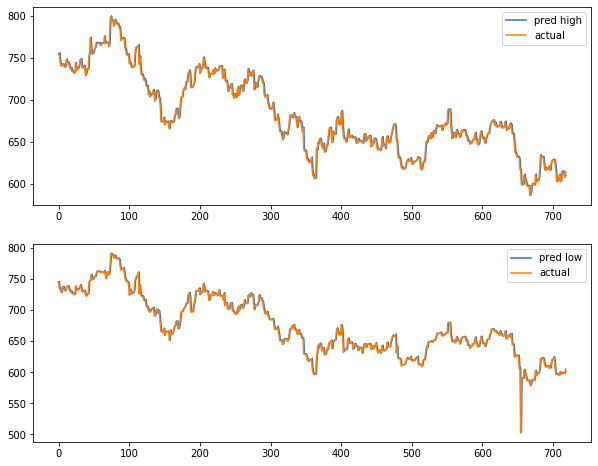

Low MSE: 58.98575545499823
Training loss: 0.00019978904823884436
Val loss high: 0.00011482082739663795
Val loss low: 0.0004843747065088046
Avg val loss 0.0002995977669527213
val loss decreased
Epoch: 7
training...


completed training
High MSE: 30.766347474898947


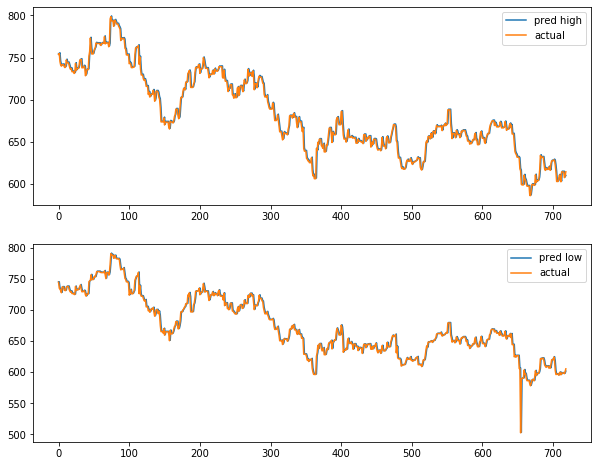

Low MSE: 58.90132413619729
Training loss: 0.00019942777865402127
Val loss high: 0.00011459878922869621
Val loss low: 0.0004841986542883247
Avg val loss 0.00029939872175851047
val loss decreased
Epoch: 8
training...


completed training
High MSE: 30.679336649304215


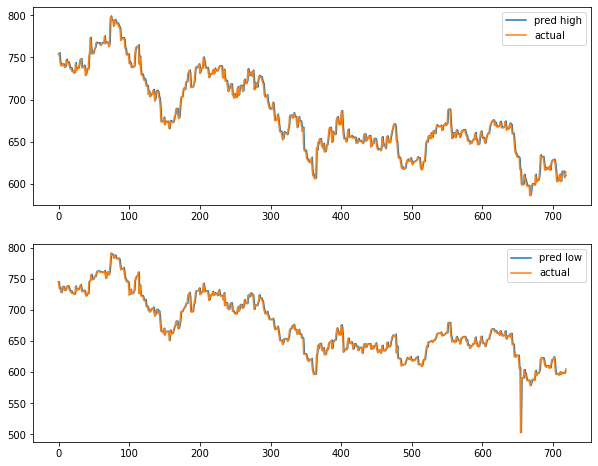

Low MSE: 58.83441738639478
Training loss: 0.00019907796599283092
Val loss high: 0.00011443070121460025
Val loss low: 0.0004840658588546581
Avg val loss 0.00029924828003462917
val loss decreased
Epoch: 9
training...


completed training
High MSE: 30.607835665445837


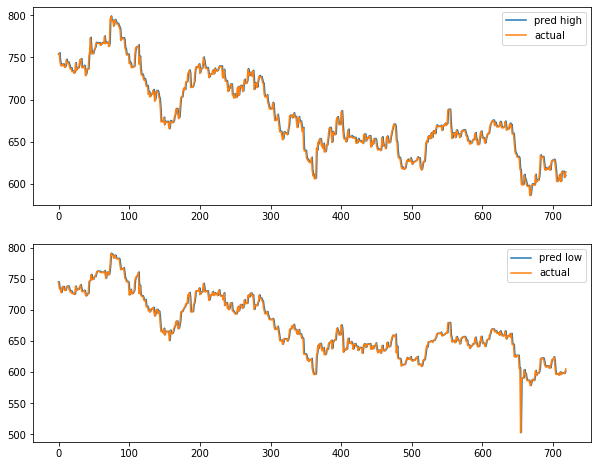

Low MSE: 58.77958014442659
Training loss: 0.0001988093693972402
Val loss high: 0.00011429787177997599
Val loss low: 0.0004839617796313633
Avg val loss 0.00029912982570566967
val loss decreased
Epoch: 10
training...


completed training
High MSE: 30.546955526472004


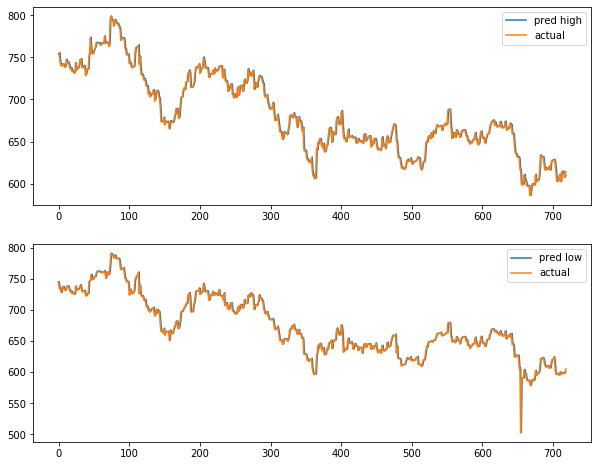

Low MSE: 58.733319008371105
Training loss: 0.0001986273773866597
Val loss high: 0.00011418895985584521
Val loss low: 0.00048387755376546346
Avg val loss 0.0002990332568106543
val loss decreased
Epoch: 11
training...


completed training
High MSE: 30.49572509592616


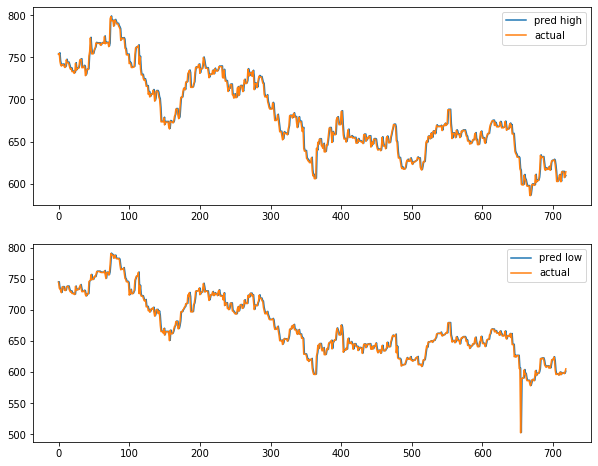

Low MSE: 58.69377941936541
Training loss: 0.00019842362904323434
Val loss high: 0.00011410041383008581
Val loss low: 0.00048380857930892853
Avg val loss 0.0002989544965695072
val loss decreased
Epoch: 12
training...


completed training
High MSE: 30.451340066889337


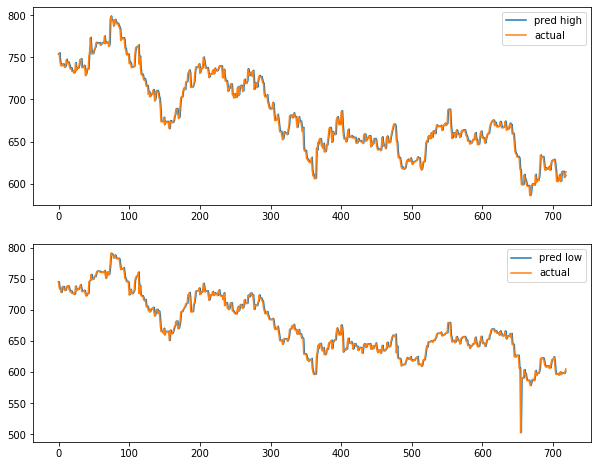

Low MSE: 58.65918264224093
Training loss: 0.00019832064804349862
Val loss high: 0.0001140260609809727
Val loss low: 0.0004837505241459379
Avg val loss 0.0002988882925634553
val loss decreased
Epoch: 13
training...


completed training
High MSE: 30.41335903455703


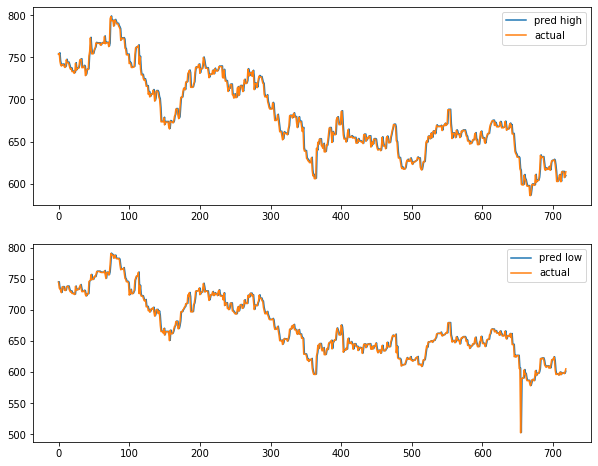

Low MSE: 58.630014365324705
Training loss: 0.00019811400561002606
Val loss high: 0.00011396456017729558
Val loss low: 0.00048370335261299163
Avg val loss 0.0002988339563951436
val loss decreased
Epoch: 14
training...


completed training
High MSE: 30.379244358642215


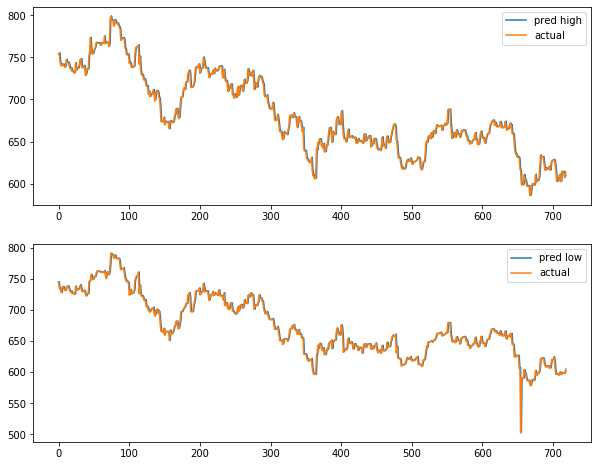

Low MSE: 58.60363190027196
Training loss: 0.00019805279748987873
Val loss high: 0.00011391093381952389
Val loss low: 0.0004836622120477591
Avg val loss 0.0002987865729336415
val loss decreased
Epoch: 15
training...


completed training
High MSE: 30.349140217635576


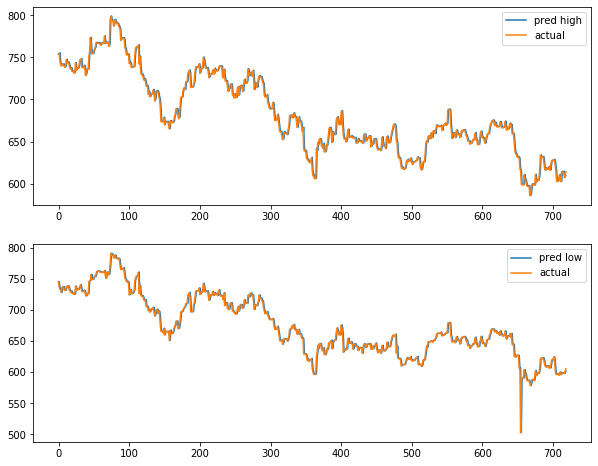

Low MSE: 58.58039254111514
Training loss: 0.0001979358791009794
Val loss high: 0.000113864947471956
Val loss low: 0.0004836271439662742
Avg val loss 0.0002987460457191151
val loss decreased
Epoch: 16
training...


completed training
High MSE: 30.322017512337027


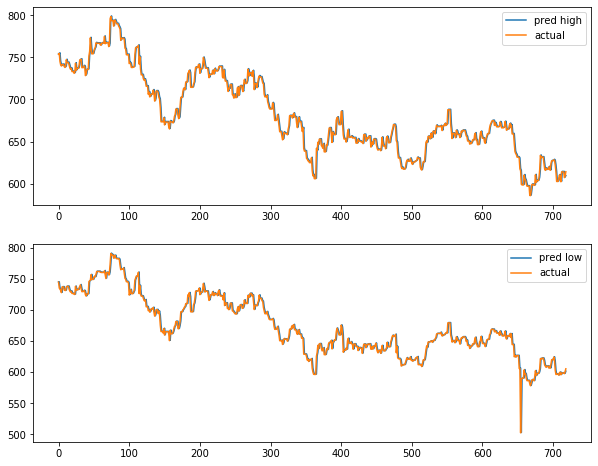

Low MSE: 58.55937793618452
Training loss: 0.00019785716696596087
Val loss high: 0.0001138247086963972
Val loss low: 0.0004835964626560138
Avg val loss 0.0002987105856762055
val loss decreased
Epoch: 17
training...


completed training
High MSE: 30.297829994673148


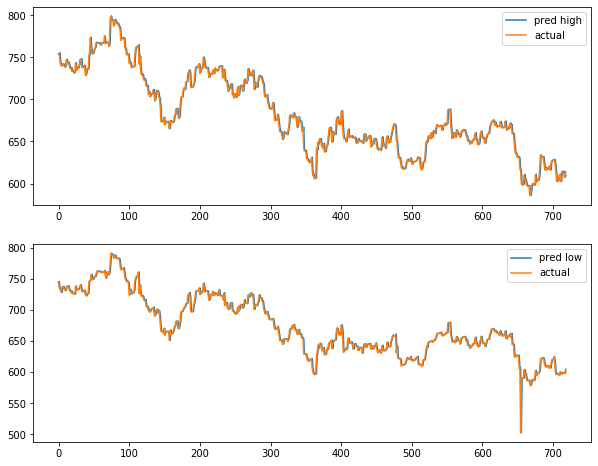

Low MSE: 58.54056118207417
Training loss: 0.00019776383956908865
Val loss high: 0.00011378978894531993
Val loss low: 0.00048356995849072417
Avg val loss 0.000298679873718022
val loss decreased
Epoch: 18
training...


completed training
High MSE: 30.275880879179997


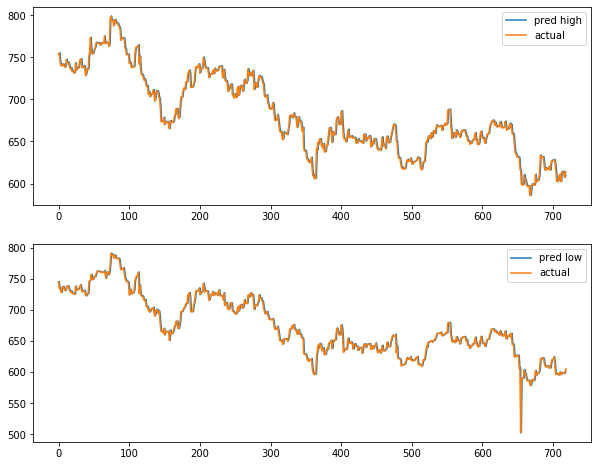

Low MSE: 58.52352899420809
Training loss: 0.00019768068826702577
Val loss high: 0.00011375897120588267
Val loss low: 0.0004835467213688087
Avg val loss 0.0002986528462873457
val loss decreased
Epoch: 19
training...


completed training
High MSE: 30.255787695990378


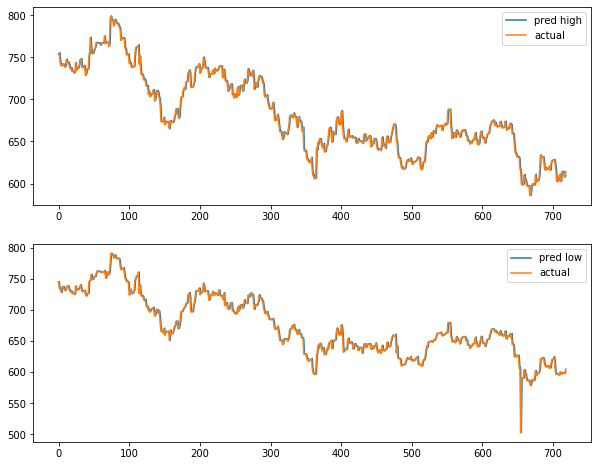

Low MSE: 58.50817896662496
Training loss: 0.00019761917730182904
Val loss high: 0.00011373146290632339
Val loss low: 0.0004835262314131007
Avg val loss 0.00029862884715971206
val loss decreased


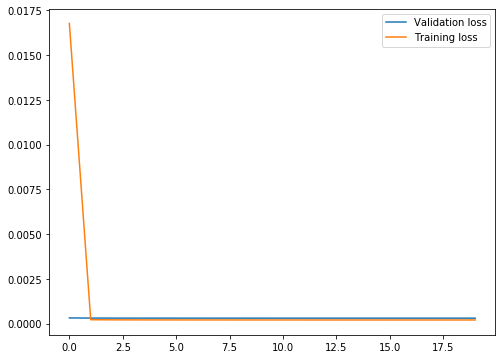

In [23]:
train_env=TrainingEnv(environment)
train_env.train()